In [1]:
version = 'v20250521'

In [2]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np
import shap

prop = 'soc'
tgt = 'soc_log1p'


covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./metric/point_predicted_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test['snr'] = test['soc']/test['pred_std']
print(test.shape)

model.fit(train[covs], train[tgt])

(5400, 424)


RandomForestRegressor(max_depth=30, max_features=0.3, min_samples_split=5,
                      n_estimators=64, n_jobs=90)

In [3]:
# rename
names = pd.read_csv(f'./metric/feature.name_selected_soc_{version}.txt', header=None)[0].tolist() 
name_map = dict(zip(covs,names))
rev_map = dict(zip(names,covs))

# get the series with 3 points SNR larger than 1
test = test.loc[test['snr']>1]
print(test.shape)
valid_ids = test['id'].value_counts()
valid_ids = valid_ids[valid_ids == 3].index
test = test[test['id'].isin(valid_ids)]
print(test.shape)

(2909, 424)
(2127, 424)


In [4]:
import random
num = random.randint(0, len(test['id'].unique())-1)
iid = test['id'].unique()[num]
pts = test.loc[test['id']==iid]

In [165]:
iid

'34482120'

In [5]:
test['error'] = test['soc'] - test['pred']

<Axes: >

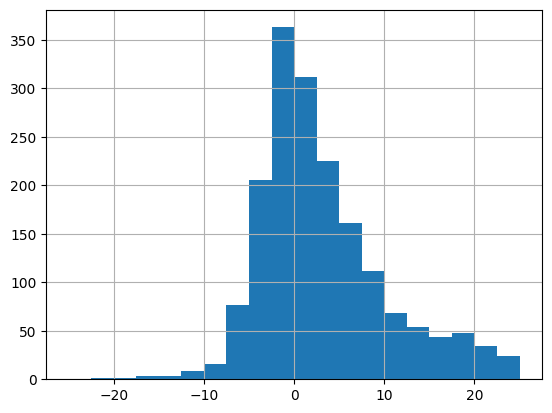

In [6]:
test['error'].hist(bins=20, range=[-25, 25])

In [166]:
pts[['time','soc','pred','lc_survey','nuts0']]

,time,soc,pred,lc_survey,nuts0
1368,2009,13.1,11.327690,cropland,ES
2220,2015,19.5,13.086047,cropland,ES
3989,2018,14.8,10.642195,grassland,ES


In [8]:
# calculate
ttprint('start calculating shap values')
# explainer = shap.TreeExplainer(model)
# shaps = explainer(test[covs])

explainer = shap.Explainer(model)
shaps = explainer(pts[covs])

ttprint('finish calculating shap values')

print('expected value: ',explainer.expected_value)
print('which is: ', np.expm1(explainer.expected_value[0]))



[14:18:15] start calculating shap values
[14:18:20] finish calculating shap values
expected value:  [3.21950785]
which is:  24.01580571386546


In [163]:
def plot_shap_figure(idx, covs, names, shaps, scaled, title):
    filtered_features = [covs[i] for i in idx]
    filtered_names = [names[i] for i in idx]
    filtered_names = [n[:-7] if n.endswith('_annual') else n for n in filtered_names]
    filtered_shaps = shaps.values[:, idx]
    filtered_scaled = scaled.iloc[:, idx].values

    mean_abs_shap = np.abs(filtered_shaps).mean(axis=0)

    order = np.argsort(-mean_abs_shap)
    filtered_names = [filtered_names[i] for i in order]
    filtered_shaps = filtered_shaps[:, order]
    filtered_scaled = filtered_scaled[:, order]
    mean_abs_shap = mean_abs_shap[order]

    fig = plt.figure(figsize=(7, 7))
    gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[20, 1], height_ratios=[1, 2, 2], wspace=0.05, hspace=0.3)

    # Bar plot
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.bar(np.arange(len(filtered_names)) + 0.5, mean_abs_shap, color='gray', width=1.0, edgecolor='white', linewidth=0.8)
    ax0.set_xlim(0, len(filtered_names))
    ax0.set_ylim(0,0.16)
    ax0.set_xticks(np.arange(0.5, len(filtered_names) + 0.5))
    ax0.set_xticklabels(filtered_names)
    ax0.set_ylabel("Mean |SHAP|",fontsize=12)
    ax0.set_title(title,fontsize=13)
    ax0.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax0.tick_params(axis='y', labelsize=12)

    # SHAP heatmap
    ax1 = fig.add_subplot(gs[1, 0])
    shapmap = sns.heatmap(filtered_shaps, ax=ax1, cmap='coolwarm',
                          cbar_ax=fig.add_subplot(gs[1, 1]),
                          xticklabels=False, yticklabels=['2009', '2015', '2018'],
                          vmin=-0.15, vmax=0.15,
                          linewidths=0.5, linecolor='white')
    ax1.set_ylabel("SHAP values",fontsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    cbar = shapmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_aspect(30)  

    # Input heatmap
    ax2 = fig.add_subplot(gs[2, 0])
    inputmap = sns.heatmap(filtered_scaled, ax=ax2, cmap='Greens',
                           cbar_ax=fig.add_subplot(gs[2, 1]), 
                           xticklabels=filtered_names, yticklabels=['2009', '2015', '2018'],
                           linewidths=0.5, linecolor='white')
    ax2.set_ylabel("Scaled feature",fontsize=12)
    # ax2.set_xlabel("Feature")
    ax2.tick_params(axis='x', rotation=90, labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    cbar = inputmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_aspect(10)  
    for label in ax2.get_xticklabels():
        label.set_ha('center')
 
    plt.savefig(f'./figure/plot_shap_{title}.svg', bbox_inches='tight')
    plt.show()


The model responds readily to different input features, as reflected by differing Shapley values—even though the three- to six-year intervals between sampling years are relatively short for SOC to meaningfully respond to environmental changes.

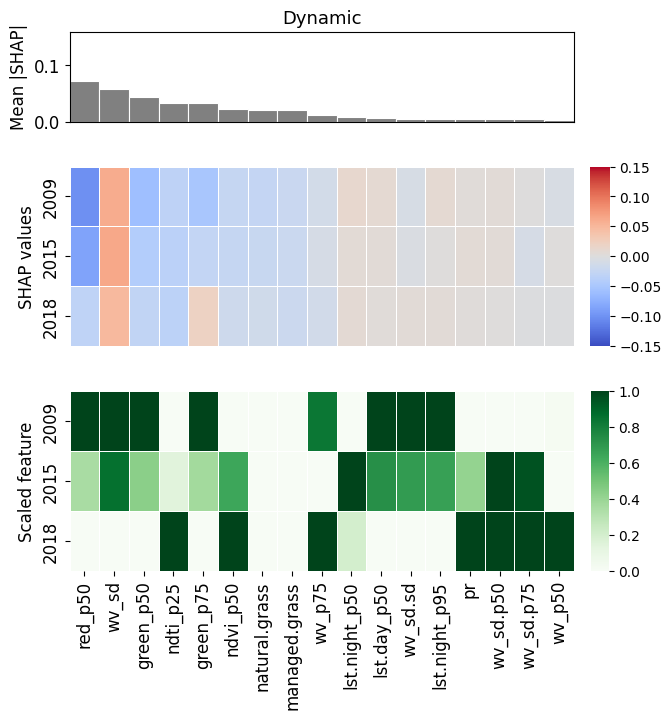

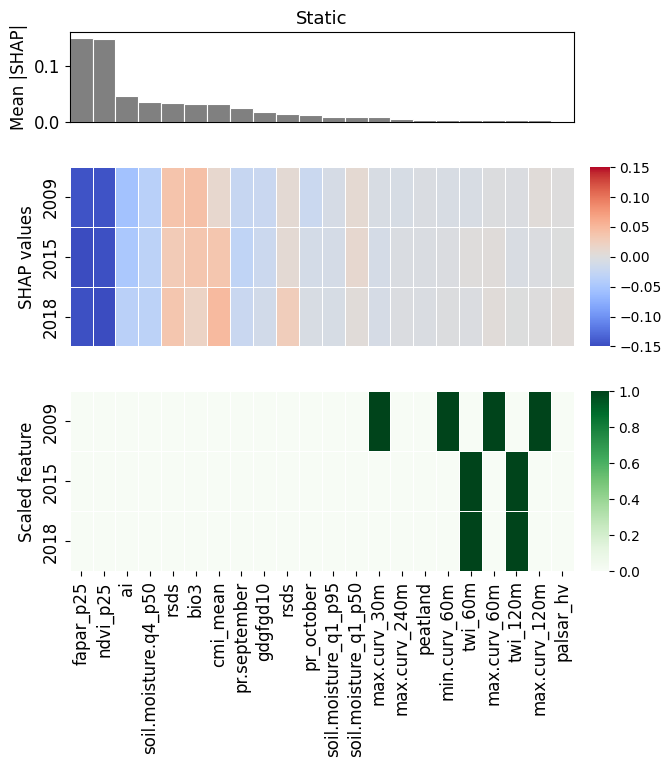

In [164]:
annual_idx = [i for i, name in enumerate(names) if "_annual" in name]
non_annual_idx = [i for i, name in enumerate(names) if "_annual" not in name]

plot_shap_figure(annual_idx, covs, names, shaps, scaled, 'Dynamic')
plot_shap_figure(non_annual_idx, covs, names, shaps, scaled, "Static")

